# RoadRunner transit model example II - custom limb darkening

*Author:* Hannu Parviainen<br>
*Last modified:* 23 April 2024

Here we look at using the *RoadRunner* transit model with a custom limb darkening model. This can be done in two ways. First, you can initialise `RoadRunnerModel` with a Python callable that return the limb darkening profile as a function of $\mu$ and a parameter vector, or you can initialise the model with a subclass of the `pytransit.LDModel`. In the first case you can also give a callable that returns the integral of the brightness profile over the stellar disk, and in the second case you can implement the integral in the class.

In [1]:
%matplotlib inline

from matplotlib.pyplot import plot, subplots, setp
from matplotlib import rc
from numpy.random import normal, uniform
from numpy import arange, array, ndarray, linspace, pi, repeat, tile, zeros

rc('figure', figsize=(13,5))

## Import the model

We start by importing the ``RoadRunnerModel`` from pytransit, and also import ``njit`` from numba to accelerate our limb darkening model.

In [2]:
from pytransit import RoadRunnerModel
from numba import njit

In [3]:
time = linspace(-0.05, 0.05, 1500)

## Approach I: give a limb darkening model as  function
### Define the limb darkening function

We use a quadratic model for a nice and familiar example, although it is also implemented as a named limb darkening model. The stellar surface brightness is

$$
I(\mu) = 1 - a(1-\mu) - b(1-\mu)^2
$$

and its integral over the stellar disk is

$$
I_\star = \int_0^1 \int_0^{2\pi} z\; I(\sqrt{1-z^2}) \;\mathrm{d}z\; \mathrm{d}\phi = \frac{2\pi}{12} (6 - 2a - b) 
$$

Note that the integral function is not required, but gives a minor performance and accuracy boost. The integral is calculated numerically for each model call if the integral function is not given, but this is fast because it only requires some additional (200 by default) limb darkening model evaluations.

In [4]:
@njit(fastmath=True)
def ld_quadratic(mu, pv):
    """Quadratic limb darkening model"""
    return 1. - pv[0] * (1. - mu) - pv[1] * (1. - mu) ** 2

@njit(fastmath=True)
def ldi_quadratic(pv):
    """Quadratic limb darkening model integrated over the stellar disk"""
    return 2*pi  * 1/12 * (-2 * pv[0] - pv[1] + 6)

### Initialise and evaluate the model

Create a model instance without (``tm1``) and with (``tm2``) the integral function. The rest of the model evaluation and setup is exactly as before.

In [5]:
tm1 = RoadRunnerModel(ld_quadratic)
tm1.set_data(time)

tm2 = RoadRunnerModel((ld_quadratic, ldi_quadratic))
tm2.set_data(time)

In [6]:
flux1 = tm1.evaluate(k=0.1, ldc=[0.56, 0.23], t0=0.0, p=1.0, a=4.2, i=0.5*pi, e=0.0, w=0.0)
flux2 = tm2.evaluate(k=0.1, ldc=[0.56, 0.23], t0=0.0, p=1.0, a=4.2, i=0.5*pi, e=0.0, w=0.0)

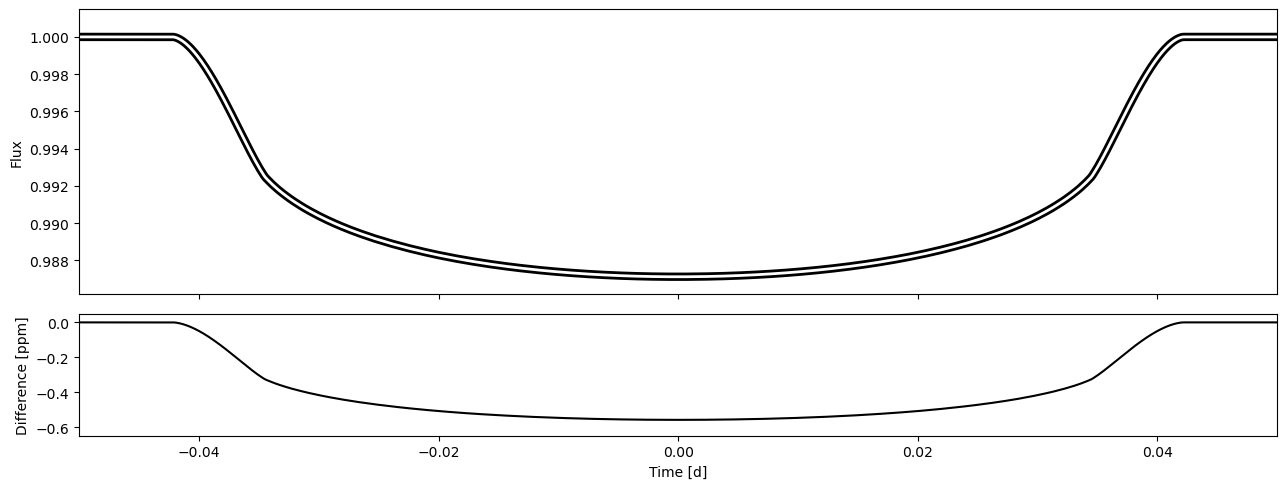

In [7]:
fig, axs = subplots(2,1, gridspec_kw={'height_ratios':(0.7,0.3)}, sharex='all')
axs[0].plot(time, flux2, lw=6, c='k')
axs[0].plot(time, flux1, lw=2, c='w')
axs[1].plot(time, 1e6*(flux1-flux2), c='k')
setp(axs, xlim=time[[0,-1]])
setp(axs[0], ylabel='Flux', ylim=(0.9862, 1.0015))
setp(axs[1], xlabel='Time [d]',ylim=(-0.65,0.05),  ylabel='Difference [ppm]')
fig.tight_layout()

## Approach II: implement the limb darkening function as a subclass of ``LDModel``

Implementing the limb darkening model as a subclass of ``LDModel`` is a bit more work, but can be the best approach when the model is something more complex than just a short equation, or if the model evaluation speed is essential. 

In [8]:
from pytransit.models.ldmodel import LDModel

The first approach (giving the limb darkening model as a function) assumes that the function evaluates the model for a single parameter vector. *PyTransit*, however, generally assumes that we're parallelising our model evaluation, and so internally deals with 3D limb darkening parameter arrays of shape ``[npv, npb, nldp]``, where ``npv`` is the number of paramter vectors, ``npb``is the number of passbands, and ``nldp`` is the number of limb darkening model specific parameters.

The *RoadRunner* model wraps the given limb darkening function with a *numba*-based wrapper that makes the model ""just work" no matter whether we give it a 1D (one parameter vector and one passband), 2D (one parameter vector but multiple passbands), or 3D (multiple parametr vectors and multiple passbands) parameter array. This wrapping adds a small overhead ($\sim10\mu$s) to the limb darkening model evaluation, which doesn't really matter much when dealing with larger real-life science cases, but it can be avoided to give limb darkening model evaluation speed below $\mu$s by
writing the model as a subclass of ``LDModel``.

``LDModel`` is a very simple class in itself. The ``__init__`` takes only the $z$ resolution for numerical integration (``niz``). The ``__call__`` method takes a $\mu$ array and an input parameter array that can be either 1D, 2D, or 3D (described later), and returns 3D limb darkening profile array and their integrals over the stellar disk calculated using the ``_evaluate`` and ``_integrate`` methods. 


    class LDModel:
        def __init__(self, niz: int = 200):
            self._int_z = linspace(0, 1, niz)
            self._int_mu = sqrt(1 - self._int_z ** 2)

        def __call__(self, mu: ndarray, x: ndarray) -> Tuple[ndarray, ndarray]:
            return self._evaluate(mu, x), self._integrate(x)

        def _evaluate(self, mu: ndarray, x:ndarray) -> ndarray:
            raise NotImplementedError

        def _integrate(self, x: ndarray) -> ndarray:
            if x.ndim == 1:
                x = x.reshape((1, 1, -1))
            elif x.ndim == 2:
                x = x.reshape((1, x.shape[1], -1))
        
            npv = x.shape[0]
            npb = x.shape[1]
            ldi = zeros((npv, npb))
            for ipv in range(npv):
                for ipb in range(npb):
                    ldi[ipv,ipb] = 2. * pi * trapz(self._int_z * self(self._int_mu, x), self._int_z)
            return ldi

### Approach II a

While subclassing ``LDModel`` is more useful for complex limb darkening models, I'll use the quadratic model as a familiar example again.

Now, we need to make sure that we return an array with shape ``[npv, npb, nmu]``, no matter the dimensionality of the input limb darkening parameter array ``pvo``. If the input array is one-dimensional, we assume ``npv = 1`` and ``npb = 1``. If it is two-dimensional, we assume ``npv = 1`` and ``npb = pvo.shape[0]``. Finally, for a three-dimensional input array, ``npv = pvo.shape[0]`` and ``npb = pvo.shape[1]``.

 First, an example where we override the ``_evaluate`` and ``_integrate`` methods separately and leave ``__call__`` untouched.

In [9]:
@njit
def _eval_quadratic(mu: ndarray, pvo: ndarray) -> ndarray:
    if pvo.ndim == 1:
        pv = pvo.reshape((1, 1, -1))
    elif pvo.ndim == 2:
        pv = pvo.reshape((1, pvo.shape[1], -1))
    else:
        pv = pvo

    npv = pv.shape[0]
    npb = pv.shape[1]
    ldp = zeros((npv, npb, mu.size))
    for ipv in range(npv):
        for ipb in range(npb):
            ldp[ipv, ipb, :] = 1. - pv[ipv, ipb, 0] * (1. - mu) - pv[ipv, ipb, 1] * (1. - mu) ** 2
    return ldp


@njit
def _integrate_quadratic(pvo: ndarray) -> ndarray:
    if pvo.ndim == 1:
        pv = pvo.reshape((1, 1, -1))
    elif pvo.ndim == 2:
        pv = pvo.reshape((1, pvo.shape[1], -1))
    else:
        pv = pvo

    npv = pv.shape[0]
    npb = pv.shape[1]
    ldi = zeros((npv, npb))
    for ipv in range(npv):
        for ipb in range(npb):
            ldi[ipv, ipb] = 2 * pi * 1 / 12 * (-2 * pv[ipv, ipb, 0] - pv[ipv, ipb, 1] + 6)
    return ldi


class QuadraticModel1(LDModel):
    
    def _evaluate(self, mu: ndarray, x:ndarray) -> ndarray:
        return _eval_quadratic(mu, x)

    def _integrate(self, x: ndarray) -> float:
        return _integrate_quadratic(x)

In [10]:
tm3 = RoadRunnerModel(QuadraticModel1())
tm3.set_data(time)

In [11]:
flux3 = tm3.evaluate(k=0.1, ldc=array([0.56, 0.23]), t0=0.0, p=1.0, a=4.2, i=0.5*pi, e=0.0, w=0.0)

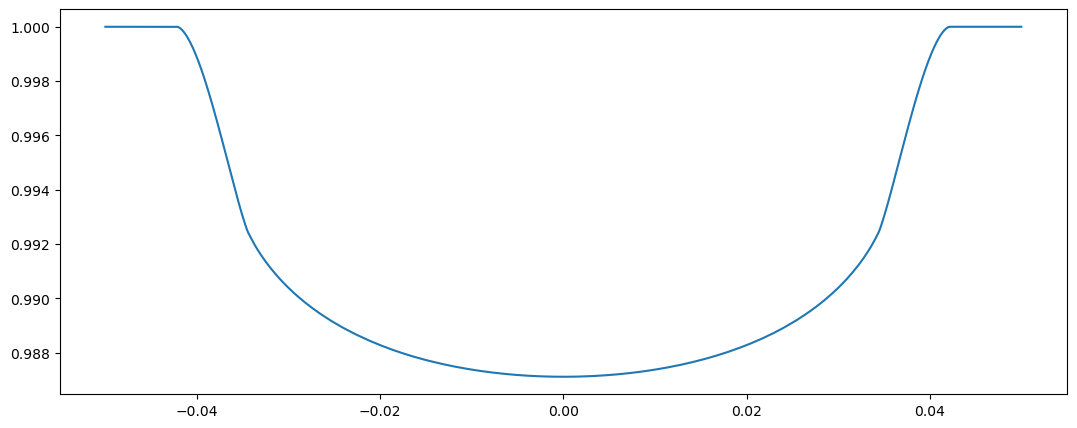

In [12]:
plot(tm3.time, flux3)

### Approach II b

Next, we do the same but in a slightly more clean and concise way. We override the ``__call__`` method and calculate both the limb darkening profile and its integral in a single function. I've also overridden the ``_evaluate`` and ``_integrate``methods to raise an error if they're called, just as a safety check.

In [13]:
@njit
def _eval_and_integrate_quadratic(mu: ndarray, pvo: ndarray) -> ndarray:
    if pvo.ndim == 1:
        pv = pvo.reshape((1, 1, -1))
    elif pvo.ndim == 2:
        pv = pvo.reshape((1, pvo.shape[1], -1))
    else:
        pv = pvo

    npv = pv.shape[0]
    npb = pv.shape[1]
    ldp = zeros((npv, npb, mu.size))
    ldi = zeros((npv, npb))
    for ipv in range(npv):
        for ipb in range(npb):
            ldp[ipv, ipb, :] = 1. - pv[ipv, ipb, 0] * (1. - mu) - pv[ipv, ipb, 1] * (1. - mu) ** 2
            ldi[ipv, ipb] = 2 * pi * 1 / 12 * (-2 * pv[ipv, ipb, 0] - pv[ipv, ipb, 1] + 6)
    return ldp, ldi


class QuadraticModel2(LDModel):    
    def __call__(self, mu: ndarray, x: ndarray):
        return _eval_and_integrate_quadratic(mu, x)

    def _evaluate(self, mu: ndarray, x:ndarray) -> ndarray:
        raise NotImplementedError("The _evaluate method is not implemented, the __call__ method "
                                  "returns both the limb darkening profile and its integral.")
  
    def _integrate(self, mu: ndarray, x:ndarray) -> ndarray:
        raise NotImplementedError("The _integrate method is not implemented, the __call__ method "
                                  "returns both the limb darkening profile and its integral.")

In [14]:
tm4 = RoadRunnerModel(QuadraticModel2())
tm4.set_data(time)

In [15]:
flux4 = tm4.evaluate(k=0.1, ldc=[0.56, 0.23], t0=0.0, p=1.0, a=4.2, i=0.5*pi, e=0.0, w=0.0)

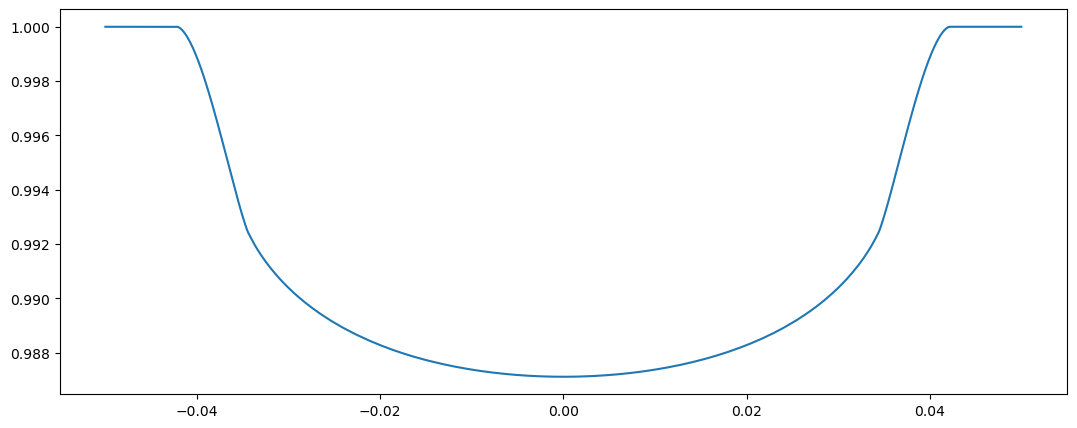

In [16]:
plot(tm4.time, flux4)

Both versions work fine but the second one is slightly faster.

In [17]:
qm1 = QuadraticModel1()
qm2 = QuadraticModel2()

In [18]:
%%timeit
qm1(tm1.mu, array([0.56, 0.23]))

1.57 µs ± 10.1 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [19]:
%%timeit
qm2(tm1.mu, array([0.56, 0.23]))

1.27 µs ± 9.39 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


---

<center>©2024 Hannu Parviainen</center>